In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [2]:
classified_dir = "classified_articles"
records = []

In [9]:
friendly_countries = {
    "br", "cn", "eg", "hk", "in", "il", "pk", "pe", "ph", "ru"
}
unfriendly_countries = {
    "au", "ca", "fr", "de", "gr", "ie", "it", "jp", 
    "nl", "no", "pt", "ro", "sg", "es", "se", "ch", 
    "tw", "ua", "gb", "us"
}

In [3]:
for filename in os.listdir(classified_dir):
    if not filename.endswith("_classified.json"):
        continue
    country_code = filename[:2].lower()
    with open(os.path.join(classified_dir, filename), "r", encoding="utf-8") as f:
        data = json.load(f)

    sentiment = data.get("sentiment", {})
    if not sentiment or not isinstance(sentiment, dict):
        continue

    # расчёт signed polarity: +pos - neg
    polarity = sentiment.get("positive", 0) - sentiment.get("negative", 0)
    topics = data.get("topics", {})

    for topic, score in topics.items():
        if isinstance(score, (float, int)):
            records.append({
                "country": country_code,
                "topic": topic,
                "topic_score": float(score),
                "polarity": polarity
            })

In [4]:
df = pd.DataFrame(records)

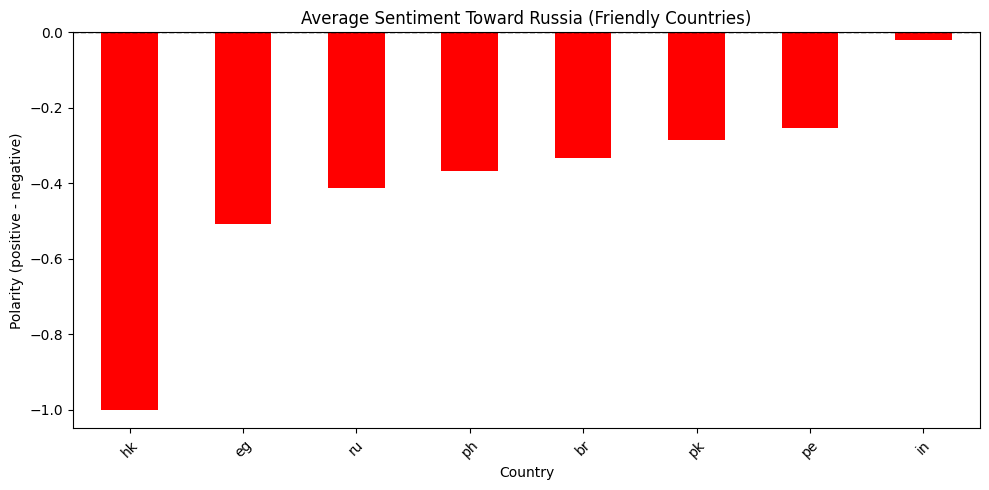

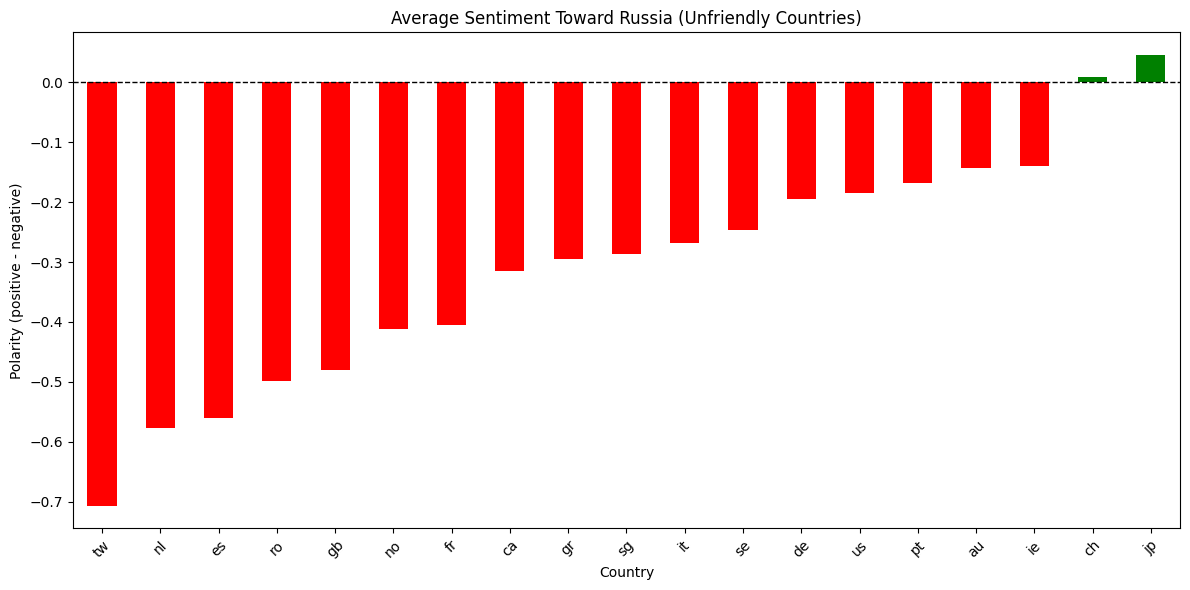

In [10]:
sentiment_by_country = df.groupby("country")["polarity"].mean()

# === Деление по группам
friendly_sentiment = sentiment_by_country[
    sentiment_by_country.index.isin(friendly_countries)
    ].sort_values()
unfriendly_sentiment = sentiment_by_country[
    sentiment_by_country.index.isin(unfriendly_countries)
    ].sort_values()

# === Цвета
friendly_colors = [
    "green" if v > 0 else "red" for v in friendly_sentiment
    ]
unfriendly_colors = [
    "green" if v > 0 else "red" for v in unfriendly_sentiment
    ]

# === График 1: дружественные страны
plt.figure(figsize=(10, 5))
friendly_sentiment.plot(kind="bar", color=friendly_colors)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Average Sentiment Toward Russia (Friendly Countries)")
plt.ylabel("Polarity (positive - negative)")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === График 2: недружественные страны
plt.figure(figsize=(12, 6))
unfriendly_sentiment.plot(kind="bar", color=unfriendly_colors)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Average Sentiment Toward Russia (Unfriendly Countries)")
plt.ylabel("Polarity (positive - negative)")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


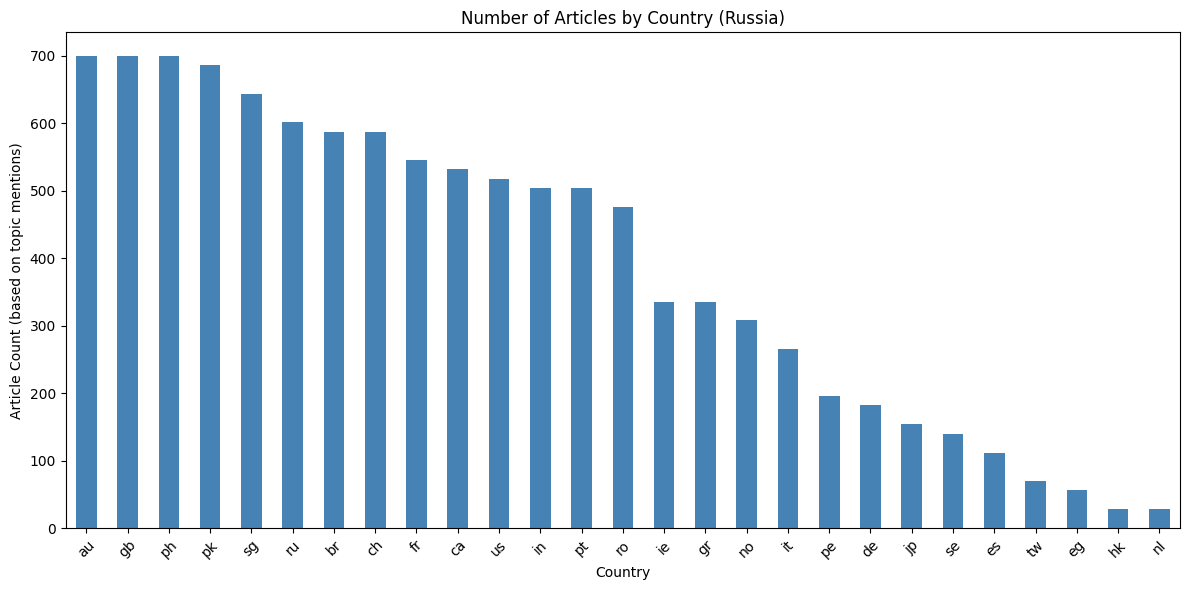

In [6]:
article_counts = df.groupby("country")["topic"].count().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
article_counts.plot(kind="bar", color="steelblue")
plt.title("Number of Articles by Country (Russia)")
plt.ylabel("Article Count (based on topic mentions)")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

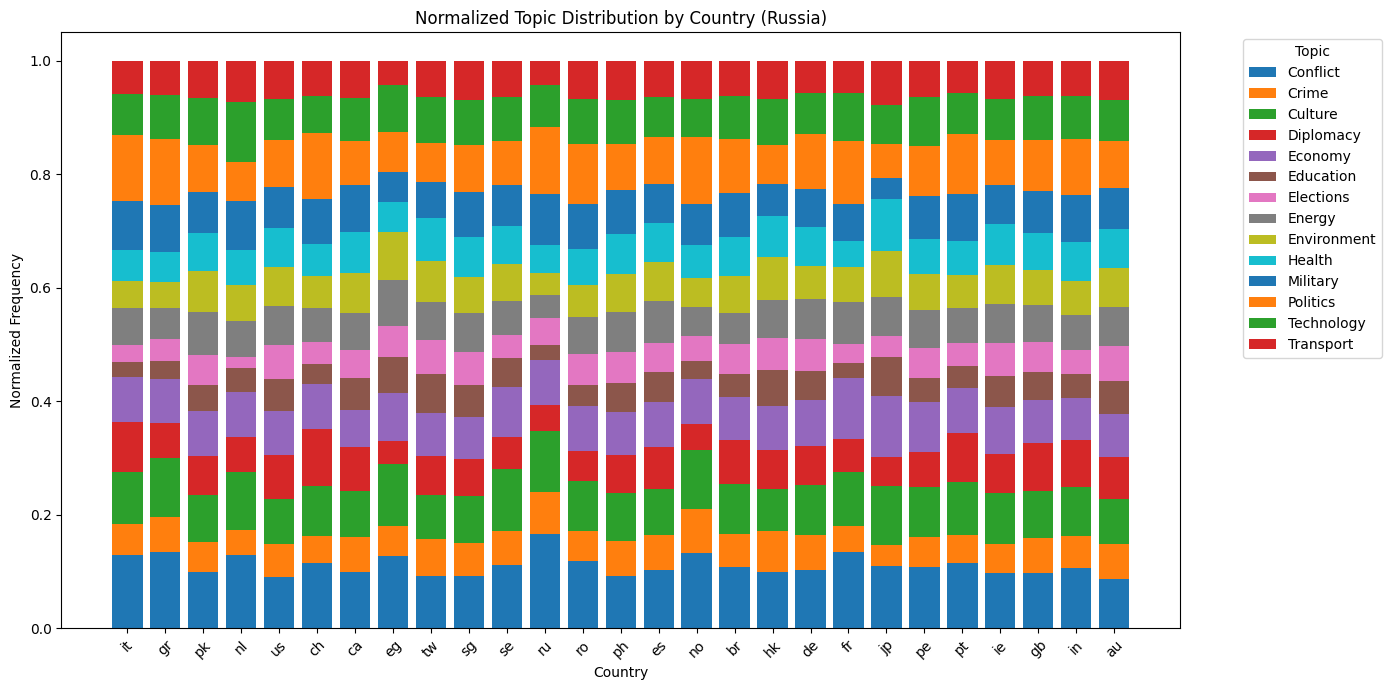

In [8]:
# суммарно по теме для каждой страны
topic_matrix = df.pivot_table(index="country", columns="topic", values="topic_score", aggfunc="mean", fill_value=0)

# нормализация по строкам
topic_matrix_norm = topic_matrix.div(topic_matrix.sum(axis=1), axis=0)

# сортировка стран по суммарному значению (можно убрать)
topic_matrix_norm = topic_matrix_norm.loc[topic_matrix_norm.sum(axis=1).sort_values(ascending=False).index]

# stacked bar
x = np.arange(len(topic_matrix_norm))
bottom = np.zeros(len(topic_matrix_norm))

plt.figure(figsize=(14, 7))
for topic in topic_matrix_norm.columns:
    values = topic_matrix_norm[topic].values
    plt.bar(x, values, bottom=bottom, label=topic)
    bottom += values

plt.xticks(x, topic_matrix_norm.index, rotation=45)
plt.title("Normalized Topic Distribution by Country (Russia)")
plt.xlabel("Country")
plt.ylabel("Normalized Frequency")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()